In [1]:
fit_results = { "tags": [], "keys": [], "a/b": [] }         # e.g tag = IPDP, key = mupi, a/b = num/num

In [64]:
tag = "IPPV"
#tag = "IPDP"
#tag = "IPPV"

In [65]:
catdict = {
    r"$\mu-\pi$"     : 20014002,
    r"$\mu-\rho$"    : 20014004,
    r"$\mu-a^{1}_{3\pi}$" : 20014008,
}
shiftdict = {
    "cp_even" : 150,
    "cp_odd"  : 151,
    "cp_maxmix"  : 0,
}
simpledict = {
    r"$\mu-\pi$"     : "mupi",
    r"$\mu-\rho$"    : "murho",
    r"$\mu-a^{1}_{3\pi}$" : "mua13pr",
}

In [66]:
import os
import re
#import ROOT
import hist
import pickle
import mplhep as hep
from glob import glob
import numpy as np
import awkward as ak
from tabulate import tabulate
from IPython import embed
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
# iminuit
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares
hep.style.use("CMS")
print("iminuit version:", iminuit.__version__)

iminuit version: 2.30.1


In [67]:
def comp_asymmetry(arr1, arr2):
    # https://github.com/Ksavva1021/TIDAL/blob/656f992ae056b3fed0061f2b3efb49905c39834d/CP_Tools/scripts/assymetry.py#L26
    return (1/arr1.size)*np.sum(np.abs((arr1-arr2)/(arr1+arr2)))

In [68]:
def makesimple(latex_str):
    # Remove LaTeX commands (e.g., $...$, \frac, \text, etc.)
    plain_text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', latex_str)  # Remove \command{...}
    print(plain_text)
    plain_text = re.sub(r'\$.*?\$', '', plain_text)  # Remove math expressions between $...$
    print(plain_text)
    plain_text = re.sub(r'\\[a-zA-Z]+', '', plain_text)  # Remove other LaTeX commands (e.g., \chi)
    print(plain_text)

    # Clean up any remaining special characters
    plain_text = plain_text.replace('$', '')  # Remove leftover dollar signs
    print(plain_text)    
    return plain_text

In [69]:
np.linspace(0., 10., 20)

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [70]:
file = f"INPUT/shifted_hist__PhiCPGen_{tag}.pickle"

In [71]:
fileptr = open(file, 'rb')
data = pickle.load(fileptr)
fileptr.close()

In [72]:
data

Hist(
  IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 4.0013e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category'),
  IntCategory([11100], growth=True, name='process'),
  IntCategory([0, 150, 151], growth=True, name='shift'),
  Variable([0, 0.314159, 0.628319, 0.942478, 1.25664, 1.5708, 1.88496, 2.19911, 2.51327, 2.82743, 3.14159, 3.45575, 3.76991, 4.08407, 4.39823, 4.71239, 5.02655, 5.34071, 5.65487, 5.96903, 6.28319], name='PhiCPGen_IPPV', label='$\\Phi_{CP}^{IP-PV}$ (rad) [Gen level]'),
  storage=Weight()) # Sum: WeightedSum(value=16389.6, variance=77.3296)

In [73]:
axes = data.axes
category_axis  = axes['category']
category_axis

IntCategory([1e+07, 200000, 1e+06, 3e+06, 15000, 300000, 10000, 11000, 16000, 2.0014e+07, 6000, 2.0014e+07, 1, 4.0013e+07, 2.0014e+07, 2.0014e+07, 100000, 9000, 4.0013e+07, 12000, 4.0013e+07, 4.0013e+07, 7000, 4000, 2.0014e+07, 4.0013e+07, 8000, 3000, 2000, 4e+06, 1000, 2e+06, 5000], growth=True, name='category')

In [74]:
shift_axis = axes['shift']
shift_axis

IntCategory([0, 150, 151], growth=True, name='shift')

In [75]:
cparray = {}
for ckey, cval in catdict.items():
    shiftarray = {}
    for key,val in shiftdict.items():
        if cval not in category_axis:
            print(f"WARNING : {cval} not in categories")
            continue
        values = data[category_axis.index(cval), :, shift_axis.index(val), :].values()
        # https://github.com/oponcet/CPinHToTauTau/blob/FF_dev_project/script_FF/fake_factor_derivation/src/input_processing.py#L133
        errors = data[category_axis.index(cval), :, shift_axis.index(val), :].variances() ** 0.5
        #shiftarray[key] = data[category_axis.index(cval), :, shift_axis.index(val), :].values()
        shiftarray[key] = [values, errors]
        print(f"category : {ckey}, CatValue : {cval}, \n Key: {key}, \t Type of value: {type(val)}, Value : {val} \n\n")
    cparray[ckey] = shiftarray
#cparray

category : $\mu-\pi$, CatValue : 20014002, 
 Key: cp_even, 	 Type of value: <class 'int'>, Value : 150 


category : $\mu-\pi$, CatValue : 20014002, 
 Key: cp_odd, 	 Type of value: <class 'int'>, Value : 151 


category : $\mu-\pi$, CatValue : 20014002, 
 Key: cp_maxmix, 	 Type of value: <class 'int'>, Value : 0 


category : $\mu-\rho$, CatValue : 20014004, 
 Key: cp_even, 	 Type of value: <class 'int'>, Value : 150 


category : $\mu-\rho$, CatValue : 20014004, 
 Key: cp_odd, 	 Type of value: <class 'int'>, Value : 151 


category : $\mu-\rho$, CatValue : 20014004, 
 Key: cp_maxmix, 	 Type of value: <class 'int'>, Value : 0 


category : $\mu-a^{1}_{3\pi}$, CatValue : 20014008, 
 Key: cp_even, 	 Type of value: <class 'int'>, Value : 150 


category : $\mu-a^{1}_{3\pi}$, CatValue : 20014008, 
 Key: cp_odd, 	 Type of value: <class 'int'>, Value : 151 


category : $\mu-a^{1}_{3\pi}$, CatValue : 20014008, 
 Key: cp_maxmix, 	 Type of value: <class 'int'>, Value : 0 




In [76]:
cparray.keys()

dict_keys(['$\\mu-\\pi$', '$\\mu-\\rho$', '$\\mu-a^{1}_{3\\pi}$'])

$\mu-\pi$


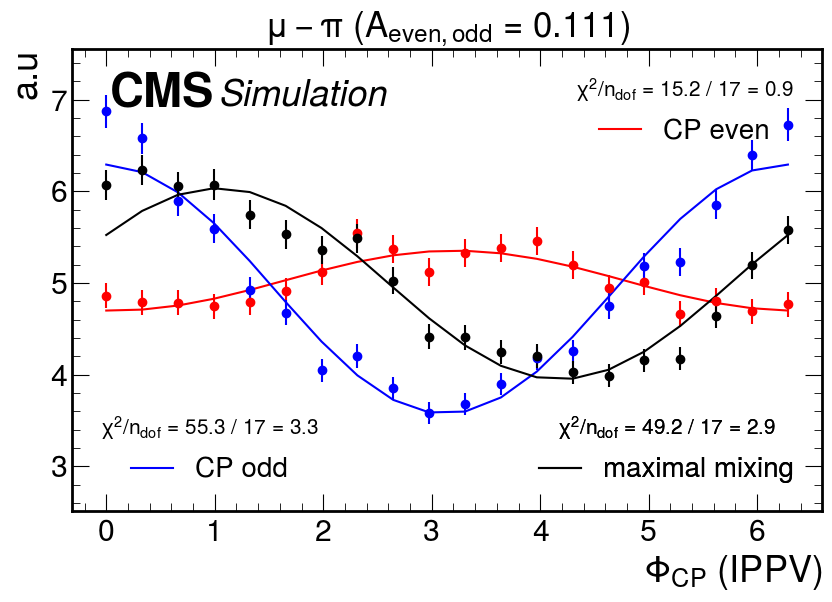

$\mu-\rho$


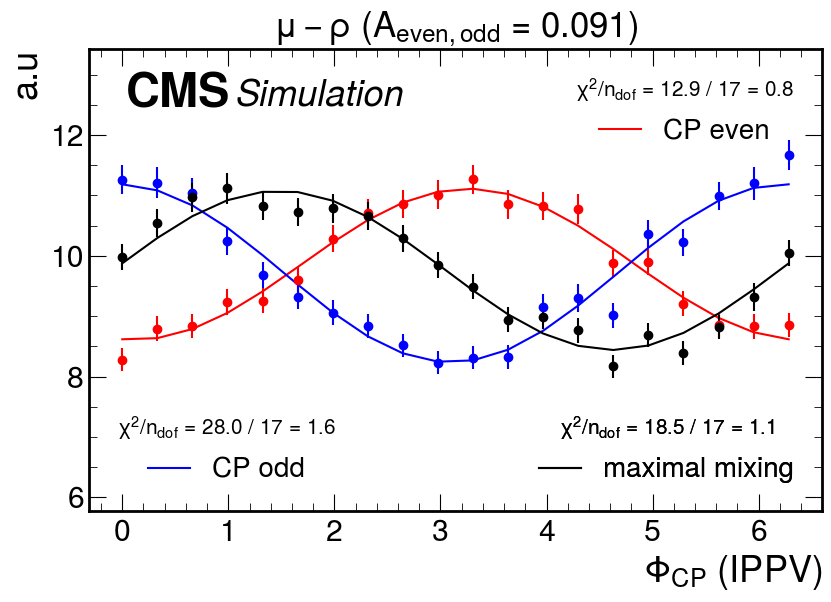

$\mu-a^{1}_{3\pi}$


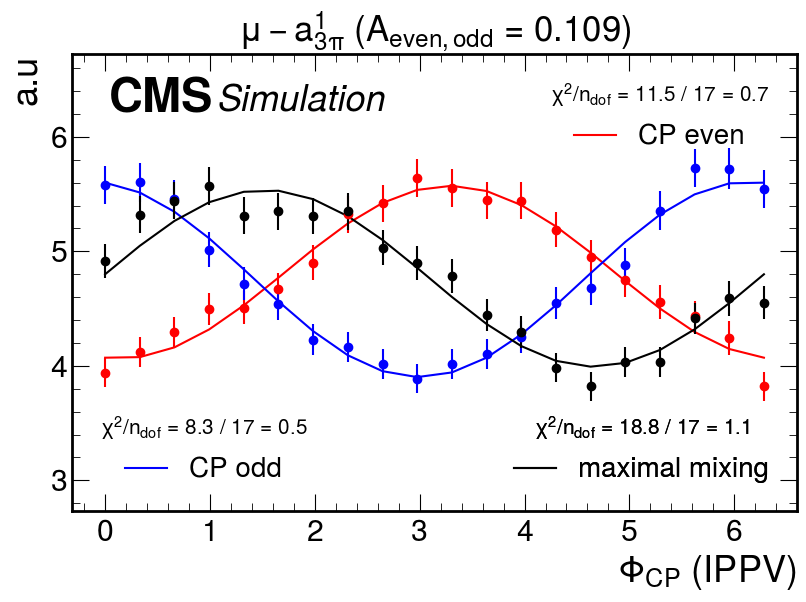

In [77]:
cpfitarray = {}
x = np.linspace(0., 2*np.pi, 20)
def model(x, a, b, c):
    return a*np.cos(x+c) + b

def fit(x, y, err=0.05, model=model):
    lsq = LeastSquares(x, y, err, model)
    m = Minuit(lsq, a=0.1, b=0.1, c=1.0)
    #m.scan(ncall=100)
    m.fixed = False
    m.migrad()  # finds minimum of least_squares function
    m.hesse()  # accurately computes uncertainties
    return m, err, m.values["a"], m.errors["a"], m.values["b"], m.errors["b"], m.values["c"]

for key, val in cparray.items():
    print(key)
    if len(val) == 0:
        print(f"WARNING : {key} has empty dict")
        continue

    even_zip = val["cp_even"]
    even, even_err = even_zip[0][0], even_zip[1][0]
    odd_zip  = val["cp_odd"]
    odd, odd_err = odd_zip[0][0], odd_zip[1][0]
    maxmix_zip = val["cp_maxmix"]
    maxmix, maxmix_err = maxmix_zip[0][0], maxmix_zip[1][0]

    # Fit and axtract parameters
    m_even, err_even, a_even, sigma_a_even, b_even, sigma_b_even, c_even = fit(x, even, even_err)
    m_odd, err_odd, a_odd, sigma_a_odd, b_odd, sigma_b_odd, c_odd = fit(x, odd, odd_err)
    m_maxmix, err_maxmix, a_maxmix, sigma_a_maxmix, b_maxmix, sigma_b_maxmix, c_maxmix = fit(x, maxmix, maxmix_err)


    # Calculate a/b and propagate uncertainties
    a_b_even = a_even / b_even
    a_b_odd = a_odd / b_odd
    a_b_maxmix = a_maxmix / b_maxmix

    sigma_ab_even = a_b_even * np.sqrt((sigma_a_even / a_even) ** 2 + (sigma_b_even / b_even) ** 2)
    sigma_ab_odd = a_b_odd * np.sqrt((sigma_a_odd / a_odd) ** 2 + (sigma_b_odd / b_odd) ** 2)
    sigma_ab_maxmix = a_b_maxmix * np.sqrt((sigma_a_maxmix / a_maxmix) ** 2 + (sigma_b_maxmix / b_maxmix) ** 2)

    # Save a/b rations for each fit
    fit_results["tags"].append(tag)
    fit_results["keys"].append(key)
    fit_results["a/b"].append({
        "a/b_even": (a_b_even, sigma_ab_even),
        "a/b_odd": (a_b_odd, sigma_ab_odd),
        "a/b_maxmix": (a_b_maxmix, sigma_ab_maxmix),
        })

    cpfitarray[key] = {"m_even": m_even, "m_odd": m_odd, "m_maxmix": m_maxmix}

    # plot
    plt.figure(figsize=(8.9, 6.6))
    #plt.subplots_adjust(top=0.85)

    # Add CMS-style text
    hep.cms.text("Simulation", loc=1)
    #plt.text(0, 21, "CMS Simulation", fontsize=12, ha='left')

    
    ### plot CP even
    plt.errorbar(x, even, even_err, fmt="o",color="red")
    #plt.scatter(x, even, color="red")
    even_fit = model(x, *m_even.values)
    lin1, = plt.plot(x, even_fit, color="red")

    # display legend with some fit info
    fit_info_even = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_even.fval:.1f} / {m_even.ndof:.0f} = {m_even.fmin.reduced_chi2:.1f}",
    ]

    #for p, v, e in zip(m.parameters, m.values, m.errors):
    #    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    leg_even_handle = Line2D([0], [0], color='red', label="CP even")
    leg_even = plt.legend(handles=[leg_even_handle],title="\n".join(fit_info_even), frameon=False, loc="upper right", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_even)


    ### plot CP odd
    plt.errorbar(x, odd, odd_err, fmt="o",color="blue")
    #plt.scatter(x, odd, color="blue")
    odd_fit = model(x, *m_odd.values)
    lin2, = plt.plot(x, odd_fit, color="blue")

    fit_info_odd = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_odd.fval:.1f} / {m_odd.ndof:.0f} = {m_odd.fmin.reduced_chi2:.1f}",
    ]

    leg_odd_handle = Line2D([0], [0], color='blue', label="CP odd")
    leg_odd = plt.legend(handles=[leg_odd_handle], title="\n".join(fit_info_odd), frameon=False, loc="lower left", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_odd)
    

    ### plot maxmix
    plt.errorbar(x, maxmix, maxmix_err, fmt="o",color="black")
    #plt.scatter(x, maxmix, color="black")
    maxmix_fit = model(x, *m_maxmix.values)
    lin3, = plt.plot(x, maxmix_fit, color="black")

    fit_info_maxmix = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m_maxmix.fval:.1f} / {m_maxmix.ndof:.0f} = {m_maxmix.fmin.reduced_chi2:.1f}",
    ]

    leg_maxmix_handle = Line2D([0], [0], color='black', label="CP maximal mixing")
    leg_maxmix = plt.legend(handles=[leg_maxmix_handle], title="\n".join(fit_info_maxmix), frameon=False, loc="lower right", fontsize=20, title_fontsize=15)
    plt.gca().add_artist(leg_maxmix)

    plt.xlabel(r"$\Phi_{CP}$"+f" ({tag})")
    plt.ylabel("a.u")

    asymm_even_odd = comp_asymmetry(even_fit, odd_fit)
    asymm_even_maxmix = comp_asymmetry(even_fit, maxmix_fit)
    asymm_odd_maxmix = comp_asymmetry(odd_fit, maxmix_fit)
    
    plt.title(f"{key} ($A_{{even,odd}}$ = {round(asymm_even_odd, 3)})", fontsize=25, loc='center')


    fits_y_min = np.min([np.min(even_fit),np.min(odd_fit),np.min(maxmix_fit)])
    fits_y_max = np.max([np.max(even_fit),np.max(odd_fit),np.max(maxmix_fit)])
    y_min = fits_y_min - 0.3 * fits_y_min
    y_max = fits_y_max + 0.2 * fits_y_max
    
    plt.ylim(y_min,y_max)

    plt.tight_layout()
    plt.savefig(f"OUTPUT/{tag}_{simpledict[key]}.pdf", dpi=300)
    plt.show()

In [78]:
fit_results

{'tags': ['IPIP',
  'IPDP',
  'IPDP',
  'IPPV',
  'IPPV',
  'IPPV',
  'IPPV',
  'IPPV',
  'IPPV'],
 'keys': ['$\\mu-\\pi$',
  '$\\mu-\\rho$',
  '$\\mu-a^{1}_{3\\pi}$',
  '$\\mu-\\pi$',
  '$\\mu-\\rho$',
  '$\\mu-a^{1}_{3\\pi}$',
  '$\\mu-\\pi$',
  '$\\mu-\\rho$',
  '$\\mu-a^{1}_{3\\pi}$'],
 'a/b': [{'a/b_even': (0.21245827881529308, np.float64(0.009094764624867855)),
   'a/b_odd': (-0.03721641506636339, np.float64(-0.009018639790013471)),
   'a/b_maxmix': (-0.14603141287617777, np.float64(-0.00924061886435739))},
  {'a/b_even': (0.15110972958347613, np.float64(0.006974098697849087)),
   'a/b_odd': (-0.14266450668015893, np.float64(-0.0070481389486890715)),
   'a/b_maxmix': (0.14061143001469806, np.float64(0.007286608176890762))},
  {'a/b_even': (0.07201307938255457, np.float64(0.00953561012368653)),
   'a/b_odd': (-0.08779887435739275, np.float64(-0.009599703103976478)),
   'a/b_maxmix': (-0.08856296659953386, np.float64(-0.010092929009935447))},
  {'a/b_even': (0.06511358194675525, np

keys : $\mu-a^{1}_{3\pi}$, tags: ['IPDP', 'IPPV', 'IPPV'], even: [(0.07201307938255457, np.float64(0.00953561012368653)), (-0.1566830068480969, np.float64(-0.009600383550306091)), (-0.1566830068480969, np.float64(-0.009600383550306091))], odd: [(-0.08779887435739275, np.float64(-0.009599703103976478)), (0.17954305765358494, np.float64(0.00973830104217747)), (0.17954305765358494, np.float64(0.00973830104217747))], maxmix: [(-0.08856296659953386, np.float64(-0.010092929009935447)), (-0.16201151004965003, np.float64(-0.009958533887106729)), (-0.16201151004965003, np.float64(-0.009958533887106729))]


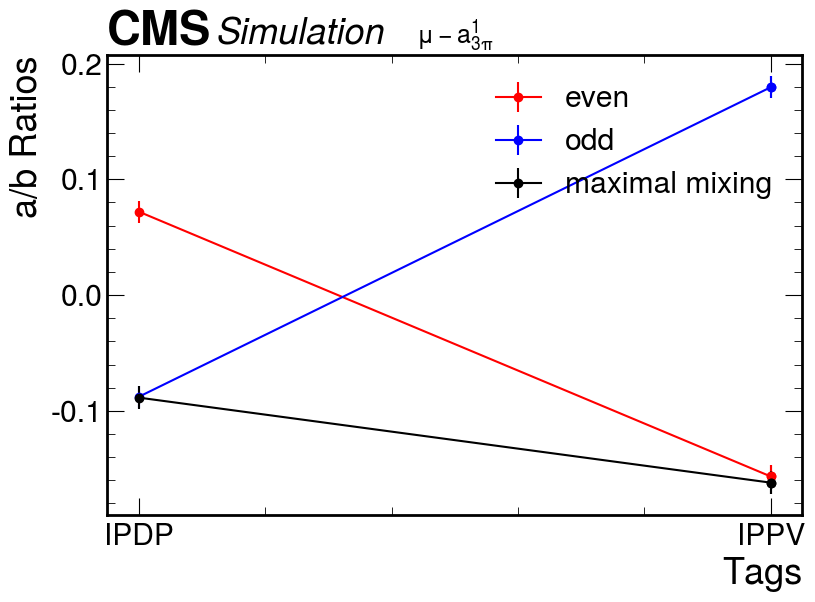

keys : $\mu-\rho$, tags: ['IPDP', 'IPPV', 'IPPV'], even: [(0.15110972958347613, np.float64(0.006974098697849087)), (-0.12688958185463506, np.float64(-0.006945341514723791)), (-0.12688958185463506, np.float64(-0.006945341514723791))], odd: [(-0.14266450668015893, np.float64(-0.0070481389486890715)), (0.1518118542407656, np.float64(0.007069607056826996)), (0.1518118542407656, np.float64(0.007069607056826996))], maxmix: [(0.14061143001469806, np.float64(0.007286608176890762)), (-0.13501273180244047, np.float64(-0.007262188529184766)), (-0.13501273180244047, np.float64(-0.007262188529184766))]


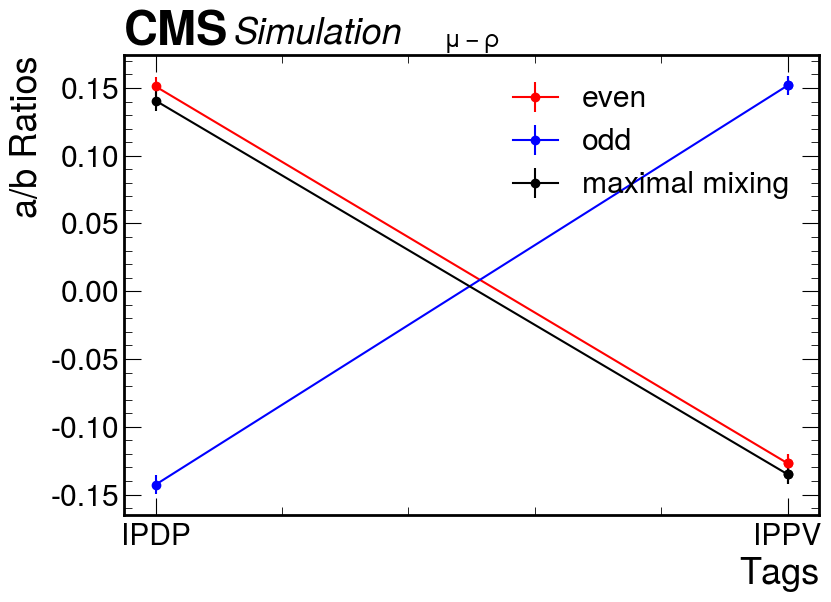

keys : $\mu-\pi$, tags: ['IPIP', 'IPPV', 'IPPV'], even: [(0.21245827881529308, np.float64(0.009094764624867855)), (0.06511358194675525, np.float64(0.00898024599292469)), (0.06511358194675525, np.float64(0.00898024599292469))], odd: [(-0.03721641506636339, np.float64(-0.009018639790013471)), (0.27548047484614585, np.float64(0.009164177254262267)), (0.27548047484614585, np.float64(0.009164177254262267))], maxmix: [(-0.14603141287617777, np.float64(-0.00924061886435739)), (-0.20897607875044916, np.float64(-0.009279678832013366)), (-0.20897607875044916, np.float64(-0.009279678832013366))]


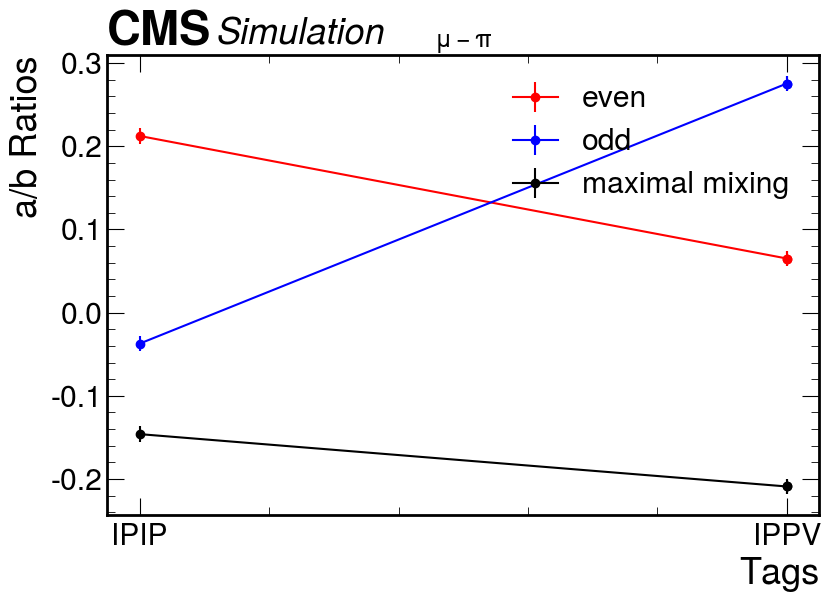

In [83]:
set_keys = set(fit_results["keys"])  # Unique keys in the results

for key in set_keys: #loops over mupi, murho, mua1

    # Extract tags and a/b ratios for this key
    
    tags = [fit_results["tags"][i] for i, k in enumerate(fit_results["keys"]) if k == key]
    a_b_ratios = [fit_results["a/b"][i] for i, k in enumerate(fit_results["keys"]) if k == key]

    # If no data for this key, skip
    if not tags or not a_b_ratios:
        print(f"No data found for key {key}, skipping...")
        continue

    # Extract ratios for existing entries
    even_ratios = [a_b.get("a/b_even", (None, None)) for a_b in a_b_ratios]
    odd_ratios = [a_b.get("a/b_odd", (None, None)) for a_b in a_b_ratios]
    maxmix_ratios = [a_b.get("a/b_maxmix", (None, None)) for a_b in a_b_ratios]

    even_vals, even_errs = zip(*even_ratios)
    odd_vals, odd_errs = zip(*odd_ratios)
    maxmix_vals, maxmix_errs = zip(*maxmix_ratios)

    even_erro = np.abs(np.array(even_errs).tolist())
    odd_erro = np.abs(np.array(odd_errs).tolist())
    maxmix_erro = np.abs(np.array(maxmix_errs).tolist())

    plt.figure(figsize=(8.9, 6.6))
    hep.cms.text("Simulation", loc=0) 

    sorted_tags = sorted(tags)

    # Plot data
    plt.errorbar(sorted_tags, even_vals, yerr=even_erro, fmt='-o', label="CP even", color="red")
    plt.errorbar(sorted_tags, odd_vals, yerr=odd_erro, fmt='-o', label="CP odd", color="blue")
    plt.errorbar(sorted_tags, maxmix_vals, yerr=maxmix_erro, fmt='-o', label="CP maximal mixing", color="black")

    print(f"keys : {key}, tags: {sorted_tags}, even: {even_ratios}, odd: {odd_ratios}, maxmix: {maxmix_ratios}")

    # Configure plot labels and save
    plt.xlabel(r"$\tau_h$ Reconstruction Method")
    plt.ylabel("a/b Ratio")
    plt.title(f"{key}", fontsize=25)
    plt.legend(frameon=False, loc="upper right")
    plt.tight_layout()
    plt.savefig(f"OUTPUT/comparison_ab_ratios_by_fit_types_{simpledict[key]}.pdf", dpi=300)
    plt.show()


In [80]:
even_erro = (even_err[0],even_err[1])
even_erro

(np.float64(0.12797222273638942), np.float64(0.13284629296538633))

In [81]:
even_erro = np.array(even_errs).tolist()
even_erro

[0.009094764624867855, 0.00898024599292469, 0.00898024599292469]

In [82]:
for i in range (0,len(even_errs)):print(even_errs[i])

0.009094764624867855
0.00898024599292469
0.00898024599292469


In [41]:
fit_results["keys"]

['$\\mu-\\pi$', '$\\mu-\\rho$', '$\\mu-a^{1}_{3\\pi}$']

In [313]:
fit_results["a/b"]

[{'a/b_even': 0.21245827881529308,
  'a/b_odd': -0.03721641506636339,
  'a/b_maxmix': -0.14603141287617777},
 {'a/b_even': 0.15110972958347613,
  'a/b_odd': -0.14266450668015893,
  'a/b_maxmix': 0.14061143001469806},
 {'a/b_even': 0.07201307938255457,
  'a/b_odd': -0.08779887435739275,
  'a/b_maxmix': -0.08856296659953386},
 {'a/b_even': 0.06511358194675525,
  'a/b_odd': 0.27548047484614585,
  'a/b_maxmix': -0.20897607875044916},
 {'a/b_even': -0.12688958185463506,
  'a/b_odd': 0.1518118542407656,
  'a/b_maxmix': -0.13501273180244047},
 {'a/b_even': -0.1566830068480969,
  'a/b_odd': 0.17954305765358494,
  'a/b_maxmix': -0.16201151004965003}]

In [215]:
print(np.min(even), np.max(even))
print(np.min(odd), np.max(odd))
print(np.min(maxmix), np.max(maxmix))

3.820163901457363 5.643370056494064
3.888557157292553 5.724572913592056
3.8204832402742284 5.575055967488993


In [63]:
cpfitarray

{'$\\mu-\\rho$': {'m_even': ┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 16.65 (χ²/ndof = 1.0)      │              Nfcn = 98               │
│ EDM = 2.82e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬───────────

In [363]:
m_maxmix

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.31 (χ²/ndof = 1.3)      │              Nfcn = 103              │
│ EDM = 4.06e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -0.42   │   0.05    │            │            │         │         │       │
│ 1 │ b    │   4.770   │   0.033   │            │            │         │         │       │
│ 2 │ c    │   -1.42   │   0.11    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────┐
│   │       a       b       c │
├───┼─────────────────────────┤
│ a │ 0.00231 -0.0001  0.0001 │
│ b │ -0.0001  0.0011  0.0003 │
│ c │  0.0001  0.0003  0.0117 │
└───┴─────────────────────────┘

In [320]:
m_odd

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 22.94 (χ²/ndof = 1.3)      │              Nfcn = 45               │
│ EDM = 1.38e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   -0.42   │   0.05    │            │            │         │         │       │
│ 1 │ b    │   4.815   │   0.034   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────┐
│   │       a       b │
├───┼─────────────────┤
│ a │ 0.00213 -0.0003 │
│ b │ -0.0003 0.00113 │
└───┴─────────────────┘

In [340]:
m_even.values

<ValueView a=0.3429219513443845 b=4.76253937186504>

In [341]:
m_maxmix.values

<ValueView a=-0.061456098623928535 b=4.747087954201987>

In [342]:
m_odd.values

<ValueView a=-0.42259449737539345 b=4.81529803132753>

In [343]:
x

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])

In [75]:
"""
pipi_even = cparray["rho_rho"]["cp_even"]
pipi_odd = cparray["rho_rho"]["cp_odd"]
pipi_even, pipi_odd

np.sqrt(np.mean((pipi_even - pipi_odd) ** 2))

comp_asymmetry(pipi_even,pipi_odd)

x = np.linspace(0., 2*np.pi, 20)
y = pipi_odd[0]

def model(x, a, b):
    return a*np.cos(x) + b

x, y

least_squares = LeastSquares(x, y, 0.1, model)
m = Minuit(least_squares, a=0.1, b=0.1)

#m.limits = (0.0, 2*np.pi)
m.scan(ncall=100)
m.fixed = False
m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

m.values

x

y = model(x, *m.values)

y
"""

'\npipi_even = cparray["rho_rho"]["cp_even"]\npipi_odd = cparray["rho_rho"]["cp_odd"]\npipi_even, pipi_odd\n\nnp.sqrt(np.mean((pipi_even - pipi_odd) ** 2))\n\ncomp_asymmetry(pipi_even,pipi_odd)\n\nx = np.linspace(0., 2*np.pi, 20)\ny = pipi_odd[0]\n\ndef model(x, a, b):\n    return a*np.cos(x) + b\n\nx, y\n\nleast_squares = LeastSquares(x, y, 0.1, model)\nm = Minuit(least_squares, a=0.1, b=0.1)\n\n#m.limits = (0.0, 2*np.pi)\nm.scan(ncall=100)\nm.fixed = False\nm.migrad()  # finds minimum of least_squares function\nm.hesse()  # accurately computes uncertainties\n\nm.values\n\nx\n\ny = model(x, *m.values)\n\ny\n'